In [262]:
import os                                                              
import time   
import pickle
import sys
import numpy as np                                                     
import pandas as pd   
import seaborn as sns                                                  
import matplotlib.pyplot as plt
import math
                                                                       
from sklearn.metrics import mean_absolute_error                        
from sklearn.metrics import mean_squared_error                         
from sklearn.model_selection import train_test_split                   
from sklearn.preprocessing import StandardScaler                       
from sklearn.model_selection import train_test_split

import keras                                                           
from keras.optimizers import Adam                                      
from keras.models import Model, Sequential                             
from keras.layers import Input, Dense, Dropout, merge                  
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping 

import ase                                                             
import ase.build                                                       
from ase import Atoms                                                  
from ase.atoms import Atoms                                            
from ase.io import read, write                                         
from ase.calculators.dftb import Dftb                                  
from ase.units import Hartree, mol, kcal, Bohr                         
                                                                       
from src.Calculator import src_nogrd     
from src.Calculator.src_nogrd import dictonary_elements 
from src.Calculator.src_nogrd import symmetry_function                                                    
from src.Calculator.src_nogrd import sym_func_show                                    
from src.Calculator.src_nogrd import xyzArr_generator                                 
from src.Calculator.src_nogrd import feat_scaling_func                                
from src.Calculator.src_nogrd import at_idx_map_generator
from src.Calculator.src_nogrd import at_idx_map_generator_old
from src.Calculator.store_models import write_subnet_text
                                                                                                                           
import pickle
from itertools import combinations_with_replacement as comb_replace
                                                                       
import src.Utils.DirNav                                                
from src.Utils.dftb_traj_io import read_scan_traj
import src.Utils.netBuilder
from src.Utils.netBuilder import netBuilder

In [263]:
train_name = 'Gold_3650'
save_name = 'gold_sample_model'
train_dir = os.path.join(train_name)
save_dir = os.path.join(save_name)
geom_filename          = 'EFT23_new.xyz'
md_low_rel_e_arr_name  = 'dftb_hartree.txt'
md_high_rel_e_arr_name = 'pbe_hartree.txt'
try:
    md_dftb_ref_e_arr = np.loadtxt(md_low_rel_e_arr_name)
    md_pbe_ref_e_arr = np.loadtxt(md_high_rel_e_arr_name)
except:
    raise OSError("Cannot Read md_calc_rel_e_arr")
    #os.rmdir(save_dir)
md_train_arr_origin    = read_scan_traj(filename=geom_filename)
md_train_arr = md_train_arr_origin.copy(deep=False).reset_index(drop=True)
md_rel_energy_arr = md_pbe_ref_e_arr - md_dftb_ref_e_arr
# Get rid of error values.
nan_index = np.where(np.isnan(md_rel_energy_arr))

for idx in nan_index:
    md_train_arr.drop(idx)
    md_rel_energy_arr = md_rel_energy_arr[~np.isnan(md_rel_energy_arr)]

In [264]:
# Maintainence: Natom is a global variable 
# Assumes that the configuration does not change the Number of atoms. 
nAtoms, xyzArr = xyzArr_generator(md_train_arr)# Calculate distance dataframe from xyz coordinates
distances = src_nogrd.distances_from_xyz(xyzArr, nAtoms)

In [265]:
def get_elements(struct):
    struct = ase.io.read(struct, format = "xyz")
    num=list(dict.fromkeys(struct.get_atomic_numbers()))
    num.sort()
    atomic_num=[f'{str(i)}' for i in num]
    ELEMENTS=[]
    for element in atomic_num:
        ELEMENTS.append(dictonary_elements[element])
    return ELEMENTS

In [266]:
SUPPORTED_ELEMENTS=get_elements(geom_filename)

In [267]:
at_idx_map = at_idx_map_generator(md_train_arr[0])
print(at_idx_map)

{'H': array([80, 81]), 'O': array([79]), 'Au': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78])}


In [268]:
cutoff_rad = 7 #max(distances.max(1))
Rs_array = np.linspace(0.2, 7, num=14) #np.linspace(distances.min(1), max(distances.max(1)), num=int(max(distances.max(1))-min(distances.min(1))))   # based on max and min of the distances
eta_array =  5/(np.square(0.2*Rs_array))  #((max(distances.max(1))- min(distances.min(1))))/(2*np.square(min(distances.min(1))*Rs_array))
rad_params = np.array([(Rs_array[i], eta_array[i], cutoff_rad) for i in range(len(Rs_array)) ])
# angular symmetry function parameters
cutoff_ang =  5 #math.radians(min(all_ang)) #math.radians(max(all_ang))
lambd_array = np.array([-1, 1])
zeta_array = np.array([1, 4, 16]) #zeta_array = np.array([1, 4, 16])
#zeta_array = np.array([math.radians(sum(all_ang)/len(all_ang))])
eta_ang_array = np.array([0.001, 0.01, 0.05]) #eta_ang_array = np.array([0.001, 0.01, 0.05])
#eta_ang_array = np.array([math.radians(min(all_ang))])

# Each of the element need to be parametrized for all of the list. 
angList = np.array([e1+e2 for e1, e2 in comb_replace(SUPPORTED_ELEMENTS, 2)])
#print(angList)
ang_comp = {el : angList for el in SUPPORTED_ELEMENTS}
ang_params = np.array([[eta, zeta, lambd, cutoff_ang] for eta in eta_ang_array for zeta in zeta_array for lambd in lambd_array])

In [269]:
Gparam_dict = {}
for at_type in at_idx_map.keys():
   Gparam_dict[at_type] = {}
   Gparam_dict[at_type]['rad'] = {}
   for at2_rad in SUPPORTED_ELEMENTS:
           Gparam_dict[at_type]['rad'][at2_rad] = rad_params

   # This Section is already designed to be genera
   Gparam_dict[at_type]['ang'] = {}
   for at23_ang in ang_comp[at_type]:
       Gparam_dict[at_type]['ang'][at23_ang] = ang_params

In [270]:
print(Gparam_dict[at_type]['rad'].keys())
print(Gparam_dict[at_type]['ang'].keys())

dict_keys(['H', 'O', 'Au'])
dict_keys(['HH', 'HO', 'HAu', 'OO', 'OAu', 'AuAu'])


In [271]:
with open('Gfunc.pkl', 'rb') as f:
    Gfunc_data = pickle.load(f)

In [272]:
#Gfunc_data = symmetry_function(distances, at_idx_map, Gparam_dict)

In [273]:
#Gfunc_data.to_pickle('Gfunc.pkl')

In [274]:
n_symm_func = Gfunc_data['O'][at_idx_map['O'][0]].shape[1]

(array([  6.,   4.,   8.,   2.,   2.,  19.,  12.,  24.,  20.,  15.,  10.,
         23.,  13.,  14.,  23.,   7.,  25.,  27.,  19.,  17.,  27.,  21.,
         35.,  34.,  34.,  65.,  31.,  32.,  36.,  40.,  64.,  65.,  87.,
         56.,  67.,  76.,  63.,  57.,  46.,  43.,  51.,  45.,  42.,  31.,
         48.,  62.,  44.,  59.,  55.,  38.,  48.,  53.,  71.,  50.,  50.,
         79.,  92.,  93.,  71., 117.,  92., 149., 169., 240., 320., 258.,
         41.,   1.,   4.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([-2594.526258  , -2594.5256296 , -2594.52500121, -2594.52437281,
        -2594.52374441, -2594.52311602, -2594.52248762, -2594.52185922,
        -2594.52123083, -2594.52060243, -2594.51997404, -2594.51934564,
        -2594.51871724, -2594.51808885, -2594.51746045, -2594.51683205,
        -2594.51620366, -2594.51557526, -2594.51494686, -2594.51431847,
        -2594.51369007, -2594.51306167, -2594.51243328, -2594.51

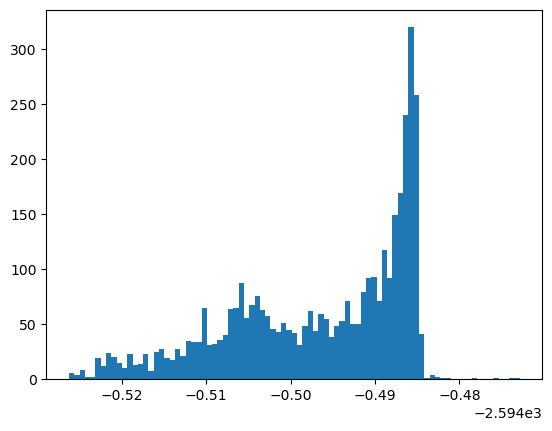

In [275]:
plt.hist(md_rel_energy_arr,bins=85)

In [419]:
duplicate__low=[i for i,v in enumerate(md_rel_energy_arr) if v < -2594.515]
clone_low=np.tile(duplicate__low,0)

In [420]:
duplicate=[i for i,v in enumerate(md_rel_energy_arr) if v > -2594.4834]
clone=np.tile(duplicate,0)

ext=np.concatenate((np.arange(len(md_rel_energy_arr)), clone), axis=0)
extension=np.concatenate((ext,clone_low),axis=0)


(array([  6.,   4.,   8.,   2.,   2.,  19.,  12.,  24.,  20.,  15.,  10.,
         23.,  13.,  14.,  23.,   7.,  25.,  27.,  19.,  17.,  27.,  21.,
         35.,  34.,  34.,  65.,  31.,  32.,  36.,  40.,  64.,  65.,  87.,
         56.,  67.,  76.,  63.,  57.,  46.,  43.,  51.,  45.,  42.,  31.,
         48.,  62.,  44.,  59.,  55.,  38.,  48.,  53.,  71.,  50.,  50.,
         79.,  92.,  93.,  71., 117.,  92., 149., 169., 240., 320., 258.,
         41.,   1.,   4.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([-2594.526258  , -2594.5256296 , -2594.52500121, -2594.52437281,
        -2594.52374441, -2594.52311602, -2594.52248762, -2594.52185922,
        -2594.52123083, -2594.52060243, -2594.51997404, -2594.51934564,
        -2594.51871724, -2594.51808885, -2594.51746045, -2594.51683205,
        -2594.51620366, -2594.51557526, -2594.51494686, -2594.51431847,
        -2594.51369007, -2594.51306167, -2594.51243328, -2594.51

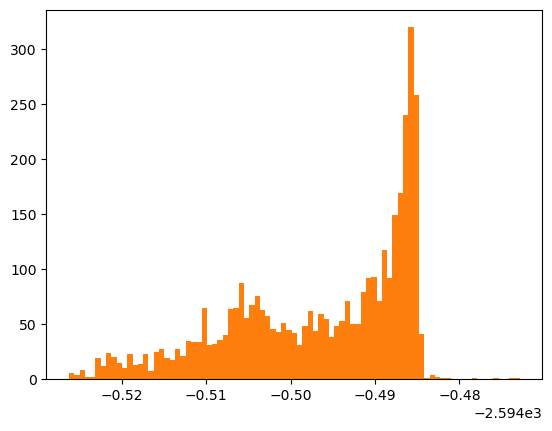

In [421]:
ext_md_rel=md_rel_energy_arr[extension]
plt.hist(ext_md_rel,bins=85)
plt.hist(md_rel_energy_arr,bins=85)

In [422]:
Dfunc_data= pd.Series([])
for at_type in at_idx_map.keys():
    Dfunc_data[at_type]= pd.Series([])
    for at in at_idx_map[at_type]:
        Dfunc_data[at_type][at] = Gfunc_data[at_type][at][extension,]


C:\Users\claud\AppData\Local\Temp\ipykernel_10316\2067547127.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Dfunc_data= pd.Series([])
C:\Users\claud\AppData\Local\Temp\ipykernel_10316\2067547127.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Dfunc_data[at_type]= pd.Series([])
C:\Users\claud\AppData\Local\Temp\ipykernel_10316\2067547127.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Dfunc_data[at_type]= pd.Series([])
C:\Users\claud\AppData\Local\Temp\ipykernel_10316\2067547127.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence 

In [423]:
sym_name = "symFunc_all.param"

with open(sym_name, "w") as all_f:
        all_f.write(f"RadialCutoff = {str(cutoff_rad)} \n")
        all_f.write("RadialParameters {\n") 
        for dist, eta in zip(Rs_array, eta_array):
            all_f.write(f"{dist} {eta}\n")
        all_f.write("}\n") 
        all_f.write(f"AngularCutoff = {str(cutoff_ang)} \n")
        all_f.write("AngularParameters {\n") 
        for row in ang_params:
            all_f.write(f"{row[0]} {row[1]} {row[2]}\n")
        all_f.write("}\n") 

In [424]:
# Glboal Var
n_samples = len(ext_md_rel)


# Maintainence // Problem: In case we have no atom for that particular element, 
# it is difficult to give the input dimension
    
# Maintain: I assume that same amount of symmetry function is used for each atom  
# Maintain: Need a input_dim_list_generator function in the future
"""
def input_dim_list_generator(element):
    # In case of element with 0 atoms in the configuration
    nAtomsForEle = len(at_idx_map(element));
    if len nAtomsForEle == 0:
        return (nAtomsForEle, )
        """
#nSymFunc = Gfunc_data['O'][0].shape[1]
n_symm_func = Dfunc_data['O'][  at_idx_map['O'][0]].shape[1]
#input_dim_list = [(len(at_idx_map[at]) ,nSymFunc, nb_feat) for at in at_idx_map.keys()]

input_dim_list = {}
for at_type in at_idx_map:
    input_dim_list[at_type] = (n_symm_func, 1)

In [425]:
n_symm_func = Dfunc_data['O'][at_idx_map['O'][0]].shape[1]
builder = netBuilder(SUPPORTED_ELEMENTS, n_symm_func)
subnets = builder.build_subnets(n_dense_layers=5, n_units=35, 
                      hidden_activation='tanh',
                      dropout_type="NoDrop", dropout_ratio=0.1)
model = builder.build_molecular_net(at_idx_map, subnets)
print(model.summary())

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
H-80-ele (InputLayer)           [(None, 156)]        0                                            
__________________________________________________________________________________________________
H-81-ele (InputLayer)           [(None, 156)]        0                                            
__________________________________________________________________________________________________
O-79-ele (InputLayer)           [(None, 156)]        0                                            
__________________________________________________________________________________________________
Au-0-ele (InputLayer)           [(None, 156)]        0                                            
______________________________________________________________________________________

In [426]:
def idx_generator(n_samples, val_ratio, test_ratio):
    """
    Function:
    Randomly shuffle the indexes and to generate indexes for the training, validation and test set.
    
        Args:
            n_samples: number of samples, an interger
            val_ratio: ratio of the validation set (compared with all data set)
            test_ratio: 
    
        Warning: 0 < val_ratio + test_ratio < 1.
    
        Output:
            train_idx: indexes for training set
            val_idx: indexes for the validation set
            test_idx: indexes for the test set    
    """
    if val_ratio + test_ratio >= 1 or val_ratio + test_ratio <= 0:
        raise  ValueError("idx_generator: the val_ratio and test_ratio must be in between 0 and 1")
    
    shuffled_indices = np.random.permutation(n_samples)
    
    
    val_set_size = int(n_samples * val_ratio)
    val_idx  = shuffled_indices[:val_set_size]
    
    test_set_size= int(n_samples * val_ratio)
    test_idx = shuffled_indices[val_set_size:val_set_size+test_set_size]
    
    train_idx = shuffled_indices[val_set_size + test_set_size:]
    
    return train_idx, val_idx, test_idx
    

In [427]:
## Split the Training, Validation & Test Data 
n_samples = len(ext_md_rel)
train_idx, val_idx, test_idx = idx_generator(n_samples, 0.1,0.1)
if train_idx.shape[0] + test_idx.shape[0] + val_idx.shape[0] != n_samples:
    raise ValueError("Splitting Test does not equal to the entire set!")

In [428]:
y_train = ext_md_rel[train_idx] 
y_val   = ext_md_rel[val_idx]
y_test  = ext_md_rel[test_idx] 



In [429]:
print('y_train min, max = ', '%.5f  %.5f' %(y_train.min(), y_train.max() ))
print('y_test min, max = ', '%.5f  %.5f' %(y_test.min(), y_test.max()) )

y_train min, max =  -2594.52626  -2594.47284
y_test min, max =  -2594.52565  -2594.48203


In [430]:
def split_training_data(Feat_data, at_idx_map, train_idx, val_idx, test_idx):
    """
    Function:
    Split the training set, 
        
    Input:
    Feat_data_train: Strucutre for the feat data Feat_data_train['element'][atom]
    at_idx_map: Atom Index Map
    train_idx: the indices used for the training 
    
    
    Output:
    Return the Feat_train, Feat_val and Feat_test set in the shape
    Feat_scaler['element'][atom][Feature Number]    
    """
    
    
    Feat_train_scaled = {}
    Feat_val_scaled = {}
    Feat_test_scaled = {}

    
    for at_type in at_idx_map.keys():
        Feat_train_scaled[at_type] = {}
        Feat_val_scaled[at_type] = {}
        Feat_test_scaled[at_type] = {}
        
        for at in at_idx_map[at_type]:
            Feat_train_scaled[at_type][at] = Feat_data[at_type][at][train_idx,]
            #import pdb; pdb.set_trace()
            Feat_val_scaled[at_type][at]   = Feat_data[at_type][at][val_idx,]
            Feat_test_scaled[at_type][at]  = Feat_data[at_type][at][test_idx,]
            

            
    
    return Feat_train_scaled, Feat_val_scaled, Feat_test_scaled



In [431]:
train_scaled, val_scaled, test_scaled = split_training_data(Dfunc_data, at_idx_map, train_idx, val_idx, test_idx)

In [432]:
inp_train = []
inp_val   = []
inp_test  = []
for at_type in at_idx_map.keys():

    for atA in at_idx_map[at_type]:
        inp_train.append(train_scaled[at_type][atA])
        #inp_train.append(Feat_train_scaled[at_type][atA])
        
        inp_val.append(val_scaled[at_type][atA])
        #inp_val.append(Feat_val_scaled[at_type][atA])
        
        inp_test.append(test_scaled[at_type][atA])
        #inp_test.append(Feat_test_scaled[at_type][atA])
        

In [433]:
def get_inp(at_idx_map, Gfunc_scaled, Feat_scaled):
    inp_arr = []
    for at_type in at_idx_map.keys():
        for at_idx in at_idx_map[at_type]:
            inp_arr.append(Gfunc_scaled[at_type][at_idx])
            inp_arr.append(Feat_scaled[at_type][at_idx])
    
    return pd.Series(inp_arr)

In [434]:
model_folder = "model_2B_nUnit"
!mkdir $model_folder
nUnit = 34

check1 = model_folder +'/' + str(nUnit) + '.hdf5'
checkpointer = ModelCheckpoint(filepath=check1, verbose=0,  monitor='val_mean_squared_error',\
                               mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=100, verbose=0)

#Mode == 'NoFirstDrop':



A subdirectory or file model_2B_nUnit already exists.


Training Session 1: Learning Rate 0.005


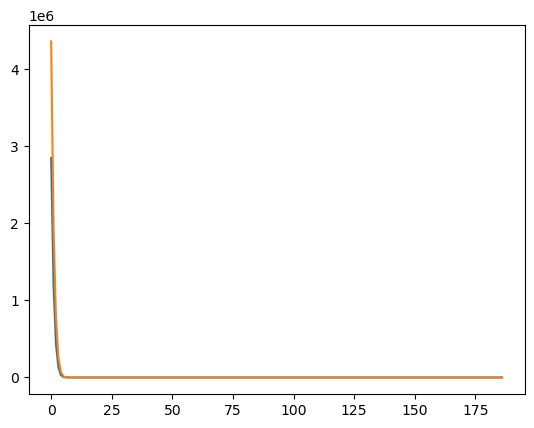

In [435]:
print("Training Session 1: Learning Rate", 5e-3)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-3,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(inp_train, y_train, \
                    callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1500, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.show()

Training Session 2: Learning Rate 0.0005


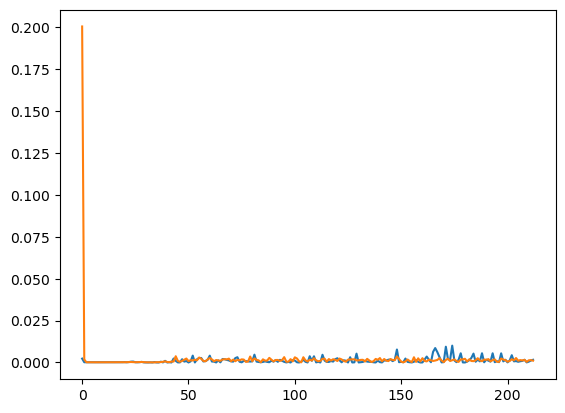

In [436]:
print("Training Session 2: Learning Rate", 5e-4)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-4,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history2 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1500, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history2.history['val_mean_squared_error'])
plt.plot(history2.history['mean_squared_error'])
plt.show()

Training Session 3: Learning Rate 0.0005


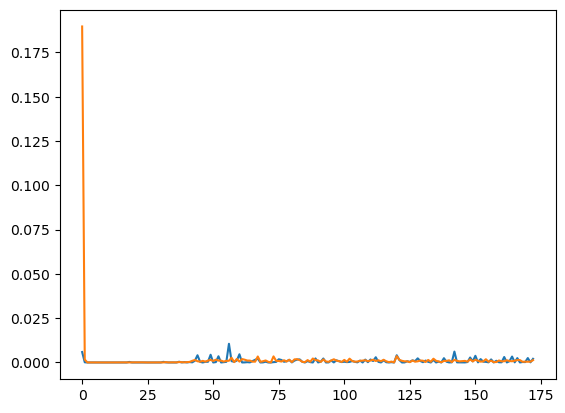

In [437]:
print("Training Session 3: Learning Rate", 5e-4)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-4,decay=5e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history3 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1500, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history3.history['val_mean_squared_error'])
plt.plot(history3.history['mean_squared_error'])
plt.show()

Training Session 4: Learning Rate 5e-05


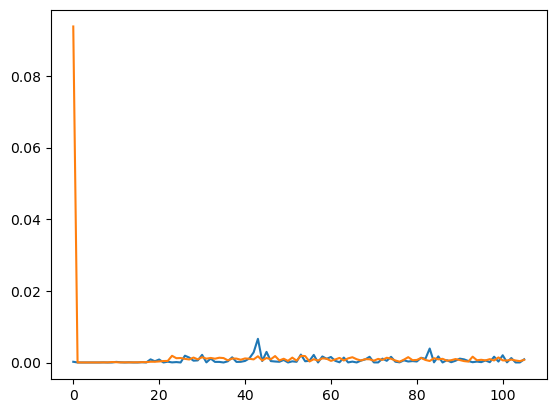

In [438]:
print("Training Session 4: Learning Rate", 5e-5)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-4,decay=5e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])


history4 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=32, epochs=1500, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history4.history['val_mean_squared_error'])
plt.plot(history4.history['mean_squared_error'])
plt.show()

Training Session 5: Learning Rate 5e-05


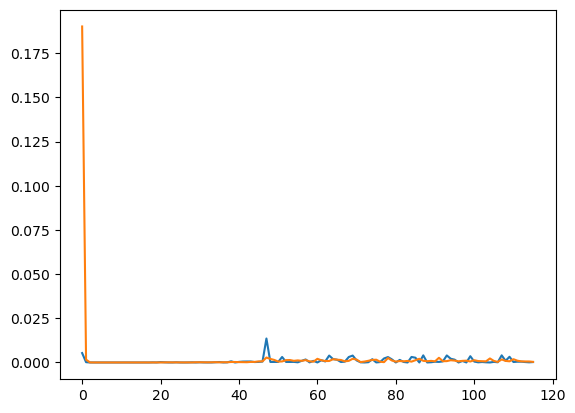

In [439]:
print("Training Session 5: Learning Rate", 5e-5)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=5e-4,decay=5e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])


history5 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1500, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )

plt.plot(history5.history['val_mean_squared_error'])
plt.plot(history5.history['mean_squared_error'])
plt.show()

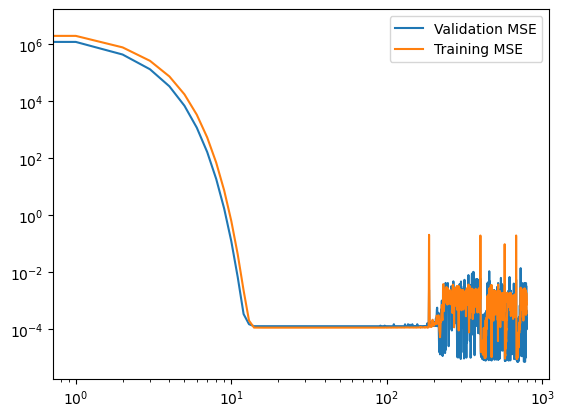

In [440]:
plt.loglog(history.history['val_mean_squared_error'] + history2.history['val_mean_squared_error'] \
           + history3.history['val_mean_squared_error']+ history4.history['val_mean_squared_error'] \
           + history5.history['val_mean_squared_error'], label='Validation MSE')
plt.loglog(history.history['mean_squared_error'] + history2.history['mean_squared_error']\
           + history3.history['mean_squared_error']+ history4.history['mean_squared_error'] \
           + history5.history['mean_squared_error'], label='Training MSE')
plt.legend()
plt.show()

In [441]:
# Load model weights
model.load_weights(check1)

c:\Users\claud\anaconda3\envs\delta\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\claud\anaconda3\envs\delta\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Training Set Fitting')

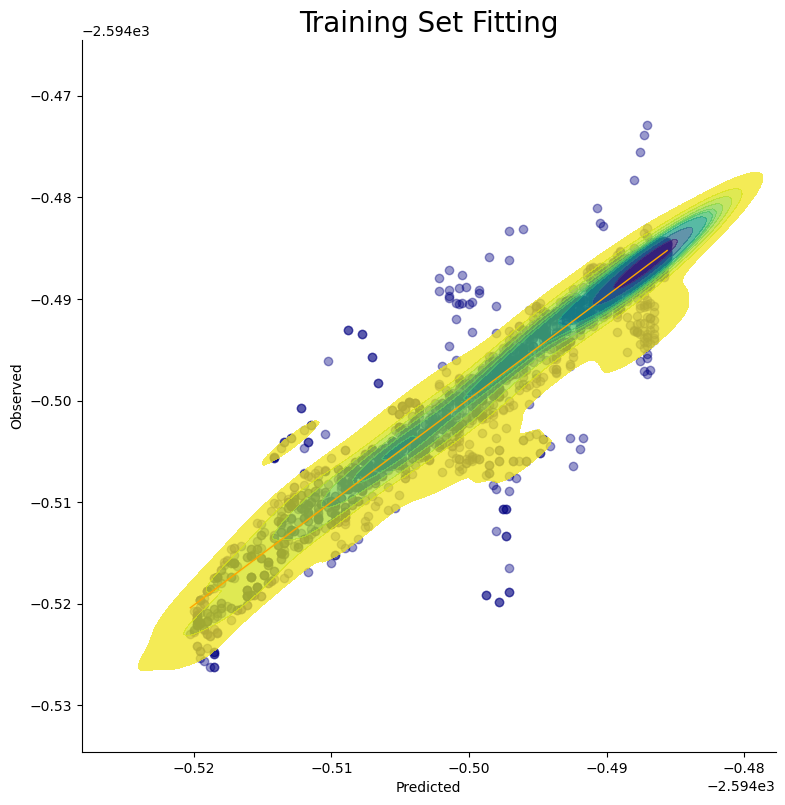

In [442]:
y_pred_scaled_train = model.predict(inp_train)
y_pred_train = y_pred_scaled_train.T[0] # Transpose the np.array
y_obs_train = y_train


x1 = pd.Series(y_pred_train, name="Predicted")
x2 = pd.Series(y_obs_train, name="Observed")

data1 = pd.concat([x1, x2], axis=1)
g = sns.lmplot("Predicted", "Observed", data1,
           scatter_kws={"marker": ".", "color": "navy", "alpha": 0.4 },
           line_kws={"linewidth": 1, "color": "orange"},

              height=8, aspect=1);
sns.kdeplot(x1,x2, cmap='viridis_r', shade=True, alpha=0.75)
plt.plot(ls="--", c=".1")
plt.title('Training Set Fitting', fontsize=20)

In [443]:
# Error on TEST set 
y_pred_scaled = model.predict(inp_test)
y_pred = y_pred_scaled.T[0]  # in kcal/mol unit
y_obs = y_test #/Eunit

err_test = np.sqrt(mean_squared_error(y_pred, y_obs))
errAbs_test = mean_absolute_error(y_pred, y_obs) 
print('RMSE_test:', '%.4f' % err_test)
print('MAE_test:','%.4f' % errAbs_test)
#print('The mean value of energies in test set: ', '%.4f' %E_ref_orig[test_idx].mean())

RMSE_test: 0.0029
MAE_test: 0.0017


c:\Users\claud\anaconda3\envs\delta\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\claud\anaconda3\envs\delta\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test Set Prediction')

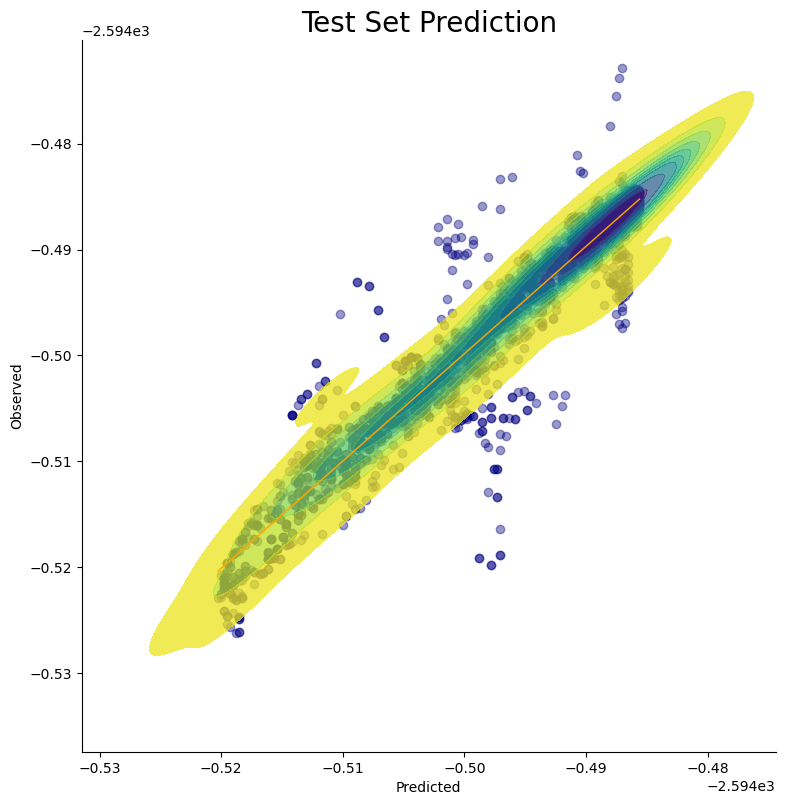

In [444]:
# Scatter plot of predicted and true values of energies in the test set
x1 = pd.Series(y_pred, name="Predicted")
x2 = pd.Series(y_obs, name="Observed")

g = sns.lmplot("Predicted", "Observed", data1,
           scatter_kws={"marker": ".", "color": "navy", "alpha": 0.4 },
           line_kws={"linewidth": 1, "color": "orange"},
              height=8, aspect=1);
sns.kdeplot(x1,x2, cmap='viridis_r', shade=True, alpha=0.75)
plt.plot(ls="--", c=".1")
plt.title('Test Set Prediction', fontsize=20)

In [445]:
# model.layers[21]
save_dir

'gold_sample_model'

In [446]:
for el in SUPPORTED_ELEMENTS:
    nm = f"{el}-subnet"
    write_subnet_text(model, 'Model', nm)

In [447]:
from keras.models import load_model

In [448]:
#TODO: Automatically collects all the sublayers. 
model.get_layer("H-subnet").save(os.path.join('Model', 'H-subnet.h5'))
model.get_layer("O-subnet").save(os.path.join('Model', 'O-subnet.h5'))
model.get_layer("Au-subnet").save(os.path.join('Model', 'Au-subnet.h5'))


In [449]:
model.save(os.path.join('Model', 'model.h5'))

In [450]:
def write_np_arr_to_pkl(np_arr, save_dir, file_name):
    with open(os.path.join(save_dir, file_name), "wb") as pkl_file:
        pickle.dump(np_arr, pkl_file)    

In [451]:
write_np_arr_to_pkl(inp_test,'Model',  "inp_test.pkl")
write_np_arr_to_pkl(y_pred,'Model',  "y_pred.pkl")
write_np_arr_to_pkl(y_obs, 'Model', "y_obs.pkl")

In [452]:
def write_keras_subnet_ind(model, save_dir, subnet_name):
    """
    Write the given subnet of keras model to file.
    
    For a given keras model (model), with the given Name of the subbnet (subnet_name, save
    the model to json file and the weight to a h5 file. 
    
        Args:
            model: a keras model for the entire nested network.
            subnet_name: the name for the sub neural network as in model.summary()
        
        Outputs:
            No Return Value.
            Save the given sub neural network in the ../folder. 
            The architecture is saved in 'subnet_name.json'
            The weight is saved in 'subnet_name-weight.h5'
            
    Comments:
    Needs to run the shell script to clean all the data
    """
    subnet = model.get_layer(subnet_name)
    subnet.save_weights(os.path.join(save_dir, subnet_name + '-weight.h5'))
    subnet_json = subnet.to_json()
    with open(os.path.join(save_dir, subnet_name+".json"), "w") as json_file:
        json_file.write(subnet_json)

In [453]:
write_keras_subnet_ind(model, 'Model', 'H-subnet')
write_keras_subnet_ind(model, 'Model', 'O-subnet')
write_keras_subnet_ind(model, 'Model', 'Au-subnet')



In [454]:
import tarfile
tar = tarfile.open("Model.tar.gz", "w:gz")
for name in ['Model/Au-subnet.param', "Model/H-subnet.param", "Model/O-subnet.param"]:
    tar.add(name)
tar.close()

In [455]:
print(md_rel_energy_arr[10:])

[-2594.50602   -2594.5063636 -2594.5069263 ... -2594.5194818 -2594.5203561
 -2594.5208995]
